### Stance and sentiment are not the same thing

In this notebook we will take a closer look and reexamine some of teh design choices we made in collecting and analyzing our data. We will show that even innocuous and seemingly small steps can lead to errors and biases. This exercise helps us become aware of how our design decisions can affect tehvalidity and reliability of our findings. 

In [2]:
import pandas as pd

We will work with an openly available Twitter dataset for stance detection: http://www.saifmohammad.com/WebPages/StanceDataset.htm


We have already seen what stance detection is, now we will compare it with sentiment. The data here are tweets and are similar to Reddit posts so we can see the types of issues our previous analysis might lead to. To stay on the lines of election prediction, we will focus on stance towards a politician --  Hillary Clinton.

In [3]:
stance_data = pd.read_csv("testdata-taskA-all-annotations.txt", sep = "\t", engine='python')
stance_data.head()

,ID,Target,Tweet,Stance,Opinion towards,Sentiment
0,10001,Atheism,He who exalts himself shall be humbled; a...,AGAINST,TARGET,POSITIVE
1,10002,Atheism,RT @prayerbullets: I remove Nehushtan -previou...,AGAINST,TARGET,NEITHER
2,10003,Atheism,@Brainman365 @heidtjj @BenjaminLives I have so...,AGAINST,TARGET,POSITIVE
3,10004,Atheism,#God is utterly powerless without Human interv...,AGAINST,TARGET,NEGATIVE
4,10005,Atheism,@David_Cameron Miracles of #Multiculturalism...,AGAINST,OTHER,NEGATIVE


We will first map stance and sentiment, assuming that negative (positive) sentiment is equivalent to against (favor)

In [4]:
stance_data = stance_data[stance_data['Target'] == "Hillary Clinton"].reset_index()

stance_mapping = {"AGAINST" : "NEGATIVE",
                 "FAVOR" : "POSITIVE",
                 "NONE" : "NEITHER"}

stance_data['Stance'] = [stance_mapping[i] for i in stance_data['Stance']]
stance_data['Tweet'][0]

'#mtp @meetthepress How is deleting emails -part of the government record -different from erasing parts of a tape? #nixon #p2 #SemST'

This is the distribution of stance

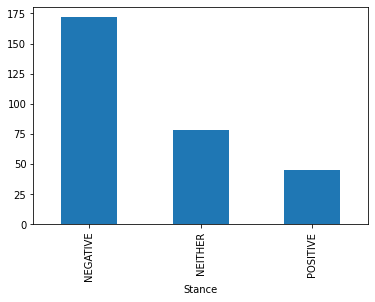

In [5]:
stance_data.groupby('Stance').size().plot(kind = 'bar')

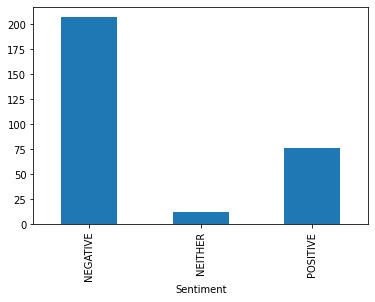

In [6]:
stance_data.groupby('Sentiment').size().plot(kind = 'bar')

The sentiment and stance distribution differ somewhat, especially for 'none'.

Now let us see some examples wehere stance and sentiment do not align.

In [7]:
mismatch = stance_data[stance_data['Stance'] != stance_data['Sentiment']].reset_index()
mismatch['Tweet'][4], mismatch['Stance'][4], mismatch['Sentiment'][4]

('The federal government did not create the states, the states created the federal government. Ronald Reagan #Federalism #SemST',
 'NEGATIVE',
 'POSITIVE')

Now we will see what the overall difference in performance results in using the 'wrong' construct.

In [8]:
from sklearn.metrics import classification_report
print(classification_report(stance_data['Stance'], stance_data['Sentiment']))

              precision    recall  f1-score   support

    NEGATIVE       0.70      0.84      0.77       172
     NEITHER       0.42      0.06      0.11        78
    POSITIVE       0.38      0.64      0.48        45

    accuracy                           0.61       295
   macro avg       0.50      0.52      0.45       295
weighted avg       0.58      0.61      0.55       295



### How accurate is VADER?

Now we will assess how good our operationalization or measure (VADER sentiment) is at measuring sentiment

In [9]:
import nltk
nltk.download('vader_lexicon')
from nltk.sentiment.vader import SentimentIntensityAnalyzer
sid = SentimentIntensityAnalyzer()

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


In [10]:
stance_data['VADER_SENTIMENT'] = [sid.polarity_scores(i)['compound'] for i in stance_data['Tweet']]
stance_data['VADER_SENTIMENT'] = ['POSITIVE' if i > 0.1 else 'NEGATIVE' if i < -0.1 else 'NEITHER' for i in stance_data['VADER_SENTIMENT']]
stance_data.head()

,index,ID,Target,Tweet,Stance,Opinion towards,Sentiment,VADER_SENTIMENT
0,674,10675,Hillary Clinton,#mtp @meetthepress How is deleting emails -par...,NEGATIVE,OTHER,NEGATIVE,NEITHER
1,675,10676,Hillary Clinton,@JDSon78 @AndrewBroering AndrewWhyDoYouCareAbo...,NEGATIVE,OTHER,NEGATIVE,NEITHER
2,676,10677,Hillary Clinton,The white male vote is solidly GOP. The black ...,NEGATIVE,OTHER,NEGATIVE,NEITHER
3,677,10678,Hillary Clinton,@nyinvesting big banker buds need to ratchet u...,NEGATIVE,TARGET,NEGATIVE,POSITIVE
4,678,10679,Hillary Clinton,@GOP Why should I believe you on this? The GOP...,NEGATIVE,OTHER,NEGATIVE,POSITIVE


In [11]:
print(classification_report(stance_data['Sentiment'], stance_data['VADER_SENTIMENT']))

              precision    recall  f1-score   support

    NEGATIVE       0.94      0.44      0.60       207
     NEITHER       0.05      0.33      0.09        12
    POSITIVE       0.50      0.82      0.62        76

    accuracy                           0.54       295
   macro avg       0.50      0.53      0.44       295
weighted avg       0.79      0.54      0.59       295



As you can see, the accuracy is around 54%. Therefore, our measure has a high error rate for *sentiment*

Next, let us see how bad VADER is at measuring the actual construct or stance.

In [12]:
print(classification_report(stance_data['Stance'], stance_data['VADER_SENTIMENT']))

              precision    recall  f1-score   support

    NEGATIVE       0.74      0.42      0.54       172
     NEITHER       0.38      0.36      0.37        78
    POSITIVE       0.24      0.67      0.36        45

    accuracy                           0.44       295
   macro avg       0.46      0.48      0.42       295
weighted avg       0.57      0.44      0.47       295



VADER has an error rate of 56% when it comes to measuring stance and this error would affect all of our findings. It seems to be worse at detecting positive stance vs negative stance.

### What is the effect of different aggregations and different populations?

Now, we will see how different aggregation or final measures can affect our findings using the Reddit elections dataset.

In [13]:
elections_df = pd.read_csv("elections.csv")
elections_df = elections_df[elections_df['Subreddit'] == 'donaldtrump']
elections_df['Sentiment'] = [sid.polarity_scores(i)['compound'] for i in elections_df['Title']]
#elections_df['Sentiment'] = ['POSITIVE' if i > 0.1 else 'NEGATIVE' if i < -0.1 else 'NEITHER' for i in elections_df['Sentiment']]
elections_df.head()

,Post ID,Title,Url,Author,Score,Publish Date,Total No. of Comments,Permalink,Flair,Subreddit,Sentiment
0,jdr9ej,Holy Hell - FBI agent investigating CHILD PORN...,https://pittsburgh.forums.rivals.com/threads/h...,TrumpFan-45,1,2020-10-19 02:00:46,8,/r/donaldtrump/comments/jdr9ej/holy_hell_fbi_a...,:snoo_scream: PANIC IN D.C. :snoo_surprised:,donaldtrump,-0.6808
1,jdracy,Biden Surrogate Arrested on Child Pornography ...,https://m.theepochtimes.com/biden-surrogate-ar...,TrumpFan-45,1,2020-10-19 02:02:26,3,/r/donaldtrump/comments/jdracy/biden_surrogate...,:snoo_scream: PANIC IN D.C. :snoo_surprised:,donaldtrump,-0.4767
2,jdrdat,Trump dancing with me while I lip sync to Upri...,https://v.redd.it/af5a6nz90yt51,leandroman,1,2020-10-19 02:07:32,2,/r/donaldtrump/comments/jdrdat/trump_dancing_w...,NaN,donaldtrump,0.0000
3,jdre50,He’s probably as high as ammo prices rn,https://i.redd.it/d4fiwz661yt51.jpg,limacharlie1776,1,2020-10-19 02:09:05,2,/r/donaldtrump/comments/jdre50/hes_probably_as...,NaN,donaldtrump,0.0000
4,jdrens,Just saw for myself a behind the scenes look a...,https://i.redd.it/oshjah3c1yt51.png,TrumpFan-45,1,2020-10-19 02:10:00,28,/r/donaldtrump/comments/jdrens/just_saw_for_my...,:snoo_scream: PANIC IN D.C. :snoo_surprised:,donaldtrump,-0.1027


#### Number of tweets per day

The first aggregation we will consider is a straightforward measure of the number of posts per day as used in some papers

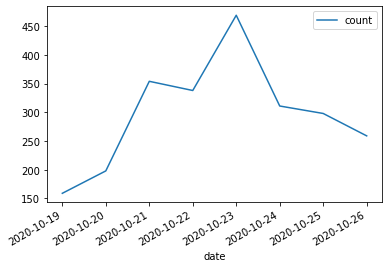

In [14]:
df = (pd.to_datetime(elections_df['Publish Date'])
       .dt.floor('d')
       .value_counts()
       .rename_axis('date')
       .reset_index(name='count'))
df.plot(x = 'date', y = 'count')

In [15]:
elections_df['date'] = pd.to_datetime(elections_df['Publish Date']).dt.floor('d')
elections_df

,Post ID,Title,Url,Author,Score,Publish Date,Total No. of Comments,Permalink,Flair,Subreddit,Sentiment,date
0,jdr9ej,Holy Hell - FBI agent investigating CHILD PORN...,https://pittsburgh.forums.rivals.com/threads/h...,TrumpFan-45,1,2020-10-19 02:00:46,8,/r/donaldtrump/comments/jdr9ej/holy_hell_fbi_a...,:snoo_scream: PANIC IN D.C. :snoo_surprised:,donaldtrump,-0.6808,2020-10-19
1,jdracy,Biden Surrogate Arrested on Child Pornography ...,https://m.theepochtimes.com/biden-surrogate-ar...,TrumpFan-45,1,2020-10-19 02:02:26,3,/r/donaldtrump/comments/jdracy/biden_surrogate...,:snoo_scream: PANIC IN D.C. :snoo_surprised:,donaldtrump,-0.4767,2020-10-19
2,jdrdat,Trump dancing with me while I lip sync to Upri...,https://v.redd.it/af5a6nz90yt51,leandroman,1,2020-10-19 02:07:32,2,/r/donaldtrump/comments/jdrdat/trump_dancing_w...,NaN,donaldtrump,0.0000,2020-10-19
3,jdre50,He’s probably as high as ammo prices rn,https://i.redd.it/d4fiwz661yt51.jpg,limacharlie1776,1,2020-10-19 02:09:05,2,/r/donaldtrump/comments/jdre50/hes_probably_as...,NaN,donaldtrump,0.0000,2020-10-19
4,jdrens,Just saw for myself a behind the scenes look a...,https://i.redd.it/oshjah3c1yt51.png,TrumpFan-45,1,2020-10-19 02:10:00,28,/r/donaldtrump/comments/jdrens/just_saw_for_my...,:snoo_scream: PANIC IN D.C. :snoo_surprised:,donaldtrump,-0.1027,2020-10-19
...,...,...,...,...,...,...,...,...,...,...,...,...
2381,jimve3,Finally saw my first Biden caravan. 50 ambulan...,https://v.redd.it/o8ec19y04iv51,meister2a,1,2020-10-26 21:45:44,0,/r/donaldtrump/comments/jimve3/finally_saw_my_...,🎭 SATIRE 🎭,donaldtrump,0.0000,2020-10-26
2382,jin678,Kamala Harris admits with a big smile she has ...,https://www.youtube.com/watch?v=0iMYlJqsDcg,saigeco,1,2020-10-26 22:00:37,1,/r/donaldtrump/comments/jin678/kamala_harris_a...,NaN,donaldtrump,0.8176,2020-10-26
2383,jin8e8,BREAKING: Biden told to STAY AWAY from childre...,https://www.youtube.com/watch?v=q81QXRqD3vs&am...,POLYTICALpod,1,2020-10-26 22:03:36,1,/r/donaldtrump/comments/jin8e8/breaking_biden_...,NaN,donaldtrump,0.0000,2020-10-26
2384,jin8rl,BUSTED: TV Journalists Blatantly LIE About Hun...,https://youtu.be/IvFzejPneoQ,Dronetek,1,2020-10-26 22:04:04,1,/r/donaldtrump/comments/jin8rl/busted_tv_journ...,NaN,donaldtrump,0.0000,2020-10-26


#### Aggregate of sentiment per day

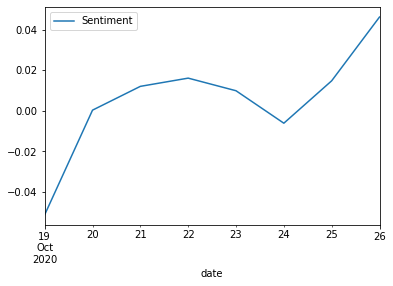

In [16]:
m = elections_df.groupby(elections_df.date).Sentiment.mean().reset_index()
m.plot(x = 'date', y = 'Sentiment')

#### Two different subreddit tell different stories

<ipython-input-27-01985e1c69a8>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  elections_df_trump['Sentiment'] = [sid.polarity_scores(i)['compound'] for i in elections_df_trump['Title']]
<ipython-input-27-01985e1c69a8>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  elections_df_trump['date'] = pd.to_datetime(elections_df_trump['Publish Date']).dt.floor('d')
<ipython-input-27-01985e1c69a8>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_i

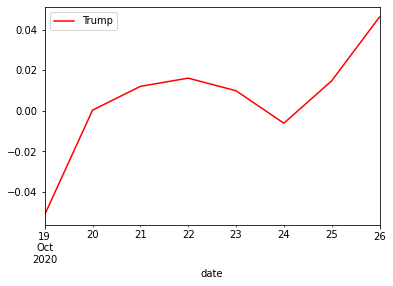

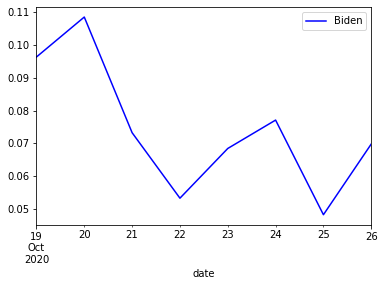

In [27]:
elections_df = pd.read_csv("elections.csv")
elections_df_trump = elections_df[elections_df['Subreddit'] == 'donaldtrump']
elections_df_biden = elections_df[elections_df['Subreddit'] == 'JoeBiden']

elections_df_trump['Sentiment'] = [sid.polarity_scores(i)['compound'] for i in elections_df_trump['Title']]
elections_df_trump['date'] = pd.to_datetime(elections_df_trump['Publish Date']).dt.floor('d')
m = elections_df_trump.groupby(elections_df_trump.date).Sentiment.mean().reset_index()
ax = m.plot(x = 'date', y = 'Sentiment', label = 'Trump', color = 'red')

elections_df_biden['Sentiment'] = [sid.polarity_scores(i)['compound'] for i in elections_df_biden['Title']]
elections_df_biden['date'] = pd.to_datetime(elections_df_biden['Publish Date']).dt.floor('d')
m = elections_df_biden.groupby(elections_df_biden.date).Sentiment.mean().reset_index()
ax = m.plot(x = 'date', y = 'Sentiment', label = 'Biden', color = 'blue')

In [23]:
elections_df.groupby('Subreddit').count()

,Post ID,Title,Url,Author,Score,Publish Date,Total No. of Comments,Permalink,Flair
Subreddit,,,,,,,,,
JoeBiden,2814,2814,2814,2814,2814,2814,2814,2814,1967
donaldtrump,2386,2386,2386,2386,2386,2386,2386,2386,1104
politics,10676,10676,10676,10676,10676,10676,10676,10676,2732
